# AI4S-Cup学习赛：小分子药物血脑屏障（BBB）渗透性分类预测 - Uni-Mol Baseline

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:0rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2023 @ Authors</i></b><br/>
        <i>作者：
            <b>
            <a href="mailto:guowentao@dp.tech">郭文韬 📨 </a> 
            <a href="mailto:wanghongshuai@dp.tech">汪鸿帅 📨 </a> 
            <a href="mailto:songk@dp.tech">宋珂 📨 </a> 
            </b>
        </i>
        <br/>
        <i>日期：2023-11-9</i><br/>
        <i>共享协议：</a>本作品采用<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">知识共享署名-非商业性使用-相同方式共享 4.0 国际许可协议</a>进行许可。</i><br/>
        <i>快速开始：点击上方的</i> <span style="background-color:rgb(85, 91, 228); color:white; padding: 3px; border-radius: 5px;box-shadow: 2px 2px 3px rgba(0, 0, 0, 0.3); font-size:0.75rem;">开始连接</span> <i>按钮，选择 <b><u>ai4s-cup-0.1</u>镜像</b>及GPU B类型节点配置，稍等片刻即可运行。
    </p>
</div>


## 1. 内容和目标 
在本示例中，我们将介绍和演示以下内容:
- Uni-Mol的主要特点 
- Uni-Mol的分子、原子表示方法 
- Uni-Mol的核心模块和相关参数 
- 如何微调超参数（如学习率 learning rate）来训练模型 
- 实际应用 

## 2. 挂载数据集路径 
本教学案例需要使用的数据，已通过Bohrium数据集功能共享给当前项目的用户。

数据集的路径为：/bohr/ai4scup-cns-5zkz/v3/

In [3]:
Dataset_Dir = '/bohr/ai4scup-cns-5zkz/v3/' 

## 2.1 读取数据，并对数据进行拆分和初步的分析 
【注】Uni-Mol进行Finetuning时，默认使用<i>5-Fold Cross Validation</i>的方式进行模型验证。 

In [4]:
import os 
import pandas as pd

# 读入数据 
train_data_full = pd.read_csv(os.path.join(Dataset_Dir, 'mol_train.csv'))
train_data_full.columns=["SMILES", "TARGET"] 
train_data_full.to_csv("./mol_train_full.csv", index=False) 

train_data_split = train_data_full[:500] 
train_data_split.columns=["SMILES", "TARGET"]
train_data_split.to_csv("./mol_train_split.csv", index=False) 

valid_data_split = train_data_full[500:] 
valid_data_split.columns=["SMILES", "TARGET"]
valid_data_split.to_csv("/data/UniMol_QSAR/mol_valid_split.csv", index=False) 

test_data = pd.read_csv(os.path.join(Dataset_Dir, 'mol_test.csv'))
test_data.columns=["SMILES", "TARGET"]
test_data.to_csv("./mol_test.csv", index=False) 

## 3. Uni-Mol的主要特点 

在开始任务之前,让我们一起了解一下Uni-Mol：分子3D表示预训练模型的主要特点。 

### 3.1. Pretrain-Finetuning，预训练-微调  
Uni-Mol提供在大数据下经过预训练（Pretraining）的模型.预训练是一种常见的深度学习策略，通常在大型数据集上进行，然后将训练得到的模型应用到特定的任务上，这通常被称为微调（Fine-tuning）。
预训练的优点有：
    1. 数据效率：预训练模型可以用少量标注数据在特定任务上达到很好的效果，因为它们已经在大规模数据集上学习了有用的特征和模式。
    2. 性能：预训练模型通常可以达到比从头开始训练更好的性能，特别是在数据稀缺的情况下。
    3. 迁移学习：预训练模型可以跨任务和领域进行迁移学习，即在一个任务上学习的知识可以用于另一个任务，这在许多实际应用中是非常有价值的。
    4. 节省时间：使用预训练模型可以节省大量的训练时间，因为不需要从零开始训练模型。

    **因此，预训练和微调是现代深度学习中的一种非常重要的策略。** 

### 3.2 Invariant spacial relation，分子坐标的旋转平移不变性
- 使用原子对的欧式距离来表征分子构象  
- 融合可学习的原子对类型,经过高斯核函数函数得到位置编码

节选代码自 https://github.com/dptech-corp Repository位置: unimol/models/unimol.py

```python
def get_dist_features(dist, et):
    n_node = dist.size(-1)
    # 通过高斯核函数smooth从而得到位置编码
    gbf_feature = self.gbf(dist, et) 
    gbf_result = self.gbf_proj(gbf_feature)
    # 通过原子对信息(距离,种类)得到自注意力机制的attention bias
    graph_attn_bias = gbf_result
    graph_attn_bias = graph_attn_bias.permute(0, 3, 1, 2).contiguous() 
    graph_attn_bias = graph_attn_bias.view(-1, n_node, n_node)
    return graph_attn_bias

graph_attn_bias = get_dist_features(src_distance, src_edge_type) 

# encode原子对信息
(encoder_rep, encoder_pair_rep, delta_encoder_pair_rep, x_norm, delta_encoder_pair_rep_norm) = self.encoder(x, padding_mask=padding_mask, attn_mask=graph_attn_bias)
encoder_pair_rep[encoder_pair_rep == float("-inf")] = 0 # 空间位置原子对信息编码
```
```python
self.gbf = GaussianLayer(K, n_edge_type) #高斯核函数
```

### 3.3 Pair representation and Attention，原子对表征通信
原子对驱动的表征作为bias，辅助更新自注意力过程

```python
# 节选代码自 https://github.com/dptech-corp Respitory位置: Uni-Mol/unimol/models/transformer_encoder_with_pair.py
# encode pairs into transformer
for i in range(len(self.layers)):
  x, attn_mask, _ = self.layers[i](x, padding_mask=padding_mask, attn_bias=attn_mask,return_attn=True)


# 节选代码自 https://github.com/dptech-corp Respitory位置: Uni-Mol/unimol/models/transformer_encoder_with_pair.py
# attention weights
attn_weights = torch.bmm(q, k.transpose(1, 2)) # get q_{ij}, 通过自注意力机制中的multi-head Query-Key乘积
#进行原子表征到原子对表征


# 节选代码自 https://github.com/dptech-corp Respitory位置: Uni-Core/unicore/modules/multihead_attention.py
# involve attention bias into attention weights
if attn_bias is not None:
    attn_weights += attn_bias #在原有weights上根据原子对信息加入bias

    
# 节选代码自 https://github.com/dptech-corp Respitory位置: Uni-Core/unicore/modules/multihead_attention.py
# 通过softmax函数得到最后的attention
attn = softmax_dropout(attn_weights, self.dropout, self.training, inplace=False,)  # softmax函数
o = torch.bmm(attn, v) # get attention
```

### 3.4 SE(3) Equivariant，SE(3)等变的坐标更新机制
* 让模型具有直接输出坐标的能力
* 更换预测目标 $X_{predict}$ -> $\Delta X_{predict}$
* SE(3) equivalent coodinate head

```python
# 节选代码自 https://github.com/dptech-corp Respitory位置: Uni-Mol/unimol/models/docking_pose.py
self.cross_distance_project = NonLinearHead(
args.mol.encoder_embed_dim * 2 + args.mol.encoder_attention_heads, 1,"relu")

self.holo_distance_project = DistanceHead(
args.mol.encoder_embed_dim + args.mol.encoder_attention_heads, "relu" )
```

## 4. Uni-Mol的分子、原子表示方法 

In [5]:
# 导入Uni-Mol 
from unimol import UniMolRepr 
import numpy as np 

# single smiles unimol representation
clf = UniMolRepr(data_type='molecule', remove_hs=False) 

smiles_list = train_data_split["SMILES"].values.tolist()[:1] 

unimol_repr = clf.get_repr(smiles_list, return_atomic_reprs=True) 

# Uni-Mol分子表征, 使用cls token 
print(np.array(unimol_repr['cls_repr']).shape) 
print(np.array(unimol_repr['cls_repr'])) 

# Uni-Mol 原子级别表征，和rdkit Mol的原子顺序一致 
print(np.array(unimol_repr['atomic_reprs']).shape) 
print(np.array(unimol_repr['atomic_reprs'])) 

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-23 18:31:23 | unimol/models/unimol.py | 116 | INFO | Uni-Mol(QSAR) | Loading pretrained weights from /opt/conda/lib/python3.8/site-packages/unimol-0.0.2-py3.8.egg/unimol/weights/mol_pre_all_h_220816.pt
2023-11-23 18:31:28 | unimol/data/conformer.py | 62 | INFO | Uni-Mol(QSAR) | Start generating conformers...
1it [00:01,  1.19s/it]
2023-11-23 18:31:29 | unimol/data/conformer.py | 66 | INFO | Uni-Mol(QSAR) | Failed to generate conformers for 0.00% of molecules.
2023-11-23 18:31:29 | unimol/data/conformer.py | 68 | INFO | Uni-Mol(QSAR) | Failed to generate 3d conformers for 0.00% of molecules.
100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

(1, 512)
[[-3.32554668e-01 -6.47540271e-01 -1.17192067e-01 -2.55985528e-01
   1.89212725e-01 -1.47828460e+00  9.14437473e-01  3.71350020e-01
  -4.63203192e-01  1.68884963e-01  1.00766444e+00  1.29866290e+00
   3.67947310e-01 -1.94589293e+00 -2.40664053e+00 -4.72459882e-01
  -1.23380733e+00 -5.64435601e-01  1.51950538e-01 -2.95339286e-01
  -7.14764655e-01 -5.22103965e-01 -1.07941818e+00 -8.52694884e-02
   1.28951846e-02  1.37045667e-01  6.51304185e-01 -1.05672657e+00
  -7.19786763e-01 -4.29590493e-01  5.67669034e-01 -4.16625530e-01
   5.63530743e-01 -1.28591311e+00  1.92323953e-01  6.53902709e-01
   3.67634386e-01 -7.90517151e-01  7.00345755e-01 -1.05778122e+00
   7.00050354e-01 -1.24514706e-01  8.04073572e-01 -1.96923316e-01
   1.75236452e+00  2.27731198e-01  2.22742820e+00  1.48964489e+00
  -2.16372192e-01 -4.72671181e-01 -1.15012836e+00  9.64360759e-02
   1.41741246e-01 -4.84767169e-01  2.11575770e+00  5.77082634e-01
   2.23466206e+00 -6.12441421e-01 -7.38597453e-01 -9.15696084e-01
 

2023-11-23 18:32:04 | unimol/data/conformer.py | 62 | INFO | Uni-Mol(QSAR) | Start generating conformers...
200it [00:03, 56.14it/s]
2023-11-23 18:32:08 | unimol/data/conformer.py | 66 | INFO | Uni-Mol(QSAR) | Failed to generate conformers for 0.00% of molecules.
2023-11-23 18:32:08 | unimol/data/conformer.py | 68 | INFO | Uni-Mol(QSAR) | Failed to generate 3d conformers for 0.00% of molecules.
100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


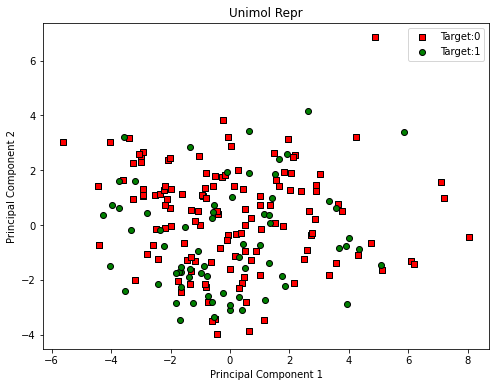

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

smiles_list = valid_data_split["SMILES"].values.tolist() 
y = valid_data_split["TARGET"].values.tolist() 
repr_dict = clf.get_repr(smiles_list)
unimol_repr_list = np.array(repr_dict['cls_repr']) 

pca = PCA(n_components=2) 
X_reduced = pca.fit_transform(unimol_repr_list) 

# 可视化
colors = ['r', 'g', 'b']
markers = ['s', 'o', 'D']
labels = ['Target:0','Target:1']

plt.figure(figsize=(8, 6))

for label, color, marker in zip(np.unique(y), colors, markers):
    plt.scatter(X_reduced[y == label, 0], 
                X_reduced[y == label, 1], 
                c=color, 
                marker=marker, 
                label=labels[label],
                edgecolors='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.title('Unimol Repr')
plt.show() 

## 5. Uni-Mol的核心模块和相关参数 

In [8]:
# 导入Uni-Mol 
from unimol import MolTrain, MolPredict 

### 5.1. “Moltrain”模块的参数说明
#### task：选择对应的任务，目前支持五种任务类型：
- classification: 0/1分类
- regression: 回归
- multiclass: 多分类
- multilabel_classification: 多标签0/1分类
- multilabel_regression: 多标签回归
#### metrics: 对应需要模型优化的指标，传入的metrics可以用逗号分隔，为空默认，目前支持的指标如下：
- classification: auc,auprc,log_loss,f1_score, mcc,recall,precision,cohen_kappa;
- regression: mae, mse, rmse, r2, spearmanr;
- multiclass: log_loss, acc;
- multilabel_classification: log_loss, acc, auprc, cohen_kappa;
- multilabel_regression: mse, mae, rmse, r2;
#### data_type：输入的数据类型，目前仅支持molecule，后续会开放protein, crystal等更多数据源 
#### split：unimol 默认采用5-Fold Cross Validation验证方式，划分方式支持random和按照scaffold划分 
#### save_path：当前的任务路径，默认会覆盖文件 
#### epochs, learning_rate, batch_size, early_stopping：unimol训练时开放的超参数

### 5.2. 超参数调整（Hyperparameter Finetuning） 
超参数是机器学习模型中的参数，其值不能通过训练数据集直接学习得到，而是需要人为设定。例如，学习率、批处理大小、训练周期数、神经网络的层数和每层的节点数等都是典型的超参数。超参数调整的目的是为了找到一组能使模型在测试数据集上表现最好的超参数。因为超参数的值直接影响到模型的训练效果和预测性能，所以合理的调整超参数对于获得高质量的机器学习模型是非常重要的。

### 5.3. Metrics 
#### 5.3.1. F2-score 
`F2-score` 是 `F1-beta` 取 $beta = 2$ 时的特殊形式。  `F1-beta` 允许我们调整精确率（Precision）和召回率（Recall）之间的权重，其一般形式如下：

$$F1-beta = (1 + beta^2) * (Precision * Recall) / (beta^2 * Precision + Recall)$$

在本次赛事中，我们更在意模型的召回率，取 $beta = 2$。此时我们得到 `F2-score`，`F2-score` 的计算公式为：

$$F2-score = 5 * (Precision * Recall) / (4 * Precision + Recall)$$

其中，Precision = 真正例（TP）/（真正例（TP）+假正例（FP）），Recall = 真正例（TP）/（真正例（TP）+假负例（FN））。
TP（True Positive）表示实际为正例且预测为正例的样本数；TN（True Negative）表示实际为负例且预测为负例的样本数；FP（False Positive）表示实际为负例但预测为正例的样本数；FN（False Negative）表示实际为正例但预测为负例的样本数。

最终排行榜展示结果只保留 `F2-score` 的四位小数，并根据F2-score来评估模型的好坏：

- 接近1的F2-score表示模型性能很好，意味着模型在正确预测正例方面做得很好，同时尽量减少了假负例（即避免将实际为正的样本预测为负）。

- 接近0的F2-score表示模型性能很差，意味着模型在正确预测正例方面做得很差，同时产生了很多假负例。

#### 5.3.2. AUC-ROC 
- AUC-ROC是一种用于评估分类模型性能的指标，全称为Area Under the Receiver Operating Characteristic Curve（接收者操作特征曲线下的面积）。在这里，ROC曲线是一个描绘了真正类率（True Positive Rate, TPR）和假正类率（False Positive Rate, FPR）在不同分类阈值下变化情况的曲线。
- 真正类率（TPR）也叫敏感性，它度量的是所有实际为正的样本中，被正确地判断为正的比例。TPR = TP / (TP + FN)，其中TP是真正类的数量，FN是假负类的数量。假正类率（FPR）度量的是所有实际为负的样本中，被错误地判断为正的比例。FPR = FP / (FP + TN)，其中FP是假正类的数量，TN是真负类的数量。
- AUC值即为ROC曲线下的面积，它反映了模型在任意分类阈值下的整体性能。AUC值在0.5到1之间，值越接近1，模型的性能越好。一般来说，如果模型的AUC值大于0.5，那么模型就比随机猜测好；如果AUC值等于0.5，那么模型的性能就等同于随机猜测；如果AUC值小于0.5，那么模型的性能就比随机猜测差。
- AUC-ROC值的优点在于，它不依赖于特定的分类阈值，因此对于评估模型的整体性能非常有用，尤其是在正负样本不均衡的情况下。

【注】本次赛题采用 `F2-score` 作为评价指标。

2023-11-23 18:32:45 | unimol/data/conformer.py | 62 | INFO | Uni-Mol(QSAR) | Start generating conformers...
700it [00:10, 69.41it/s] 
2023-11-23 18:32:55 | unimol/data/conformer.py | 66 | INFO | Uni-Mol(QSAR) | Failed to generate conformers for 0.00% of molecules.
2023-11-23 18:32:55 | unimol/data/conformer.py | 68 | INFO | Uni-Mol(QSAR) | Failed to generate 3d conformers for 0.00% of molecules.
2023-11-23 18:32:55 | unimol/train.py | 105 | INFO | Uni-Mol(QSAR) | Output directory already exists: ./full_learning_rate_1e-05
2023-11-23 18:32:55 | unimol/train.py | 106 | INFO | Uni-Mol(QSAR) | Warning: Overwrite output directory: ./full_learning_rate_1e-05
2023-11-23 18:32:56 | unimol/models/unimol.py | 116 | INFO | Uni-Mol(QSAR) | Loading pretrained weights from /opt/conda/lib/python3.8/site-packages/unimol-0.0.2-py3.8.egg/unimol/weights/mol_pre_all_h_220816.pt
2023-11-23 18:32:56 | unimol/models/nnmodel.py | 103 | INFO | Uni-Mol(QSAR) | start training Uni-Mol:unimolv1
2023-11-23 18:33:04

[Learning Rate: 1e-05]	AUC:0.8893	F2_Score:0.7525


2023-11-23 18:38:11 | unimol/data/conformer.py | 62 | INFO | Uni-Mol(QSAR) | Start generating conformers...
700it [00:10, 64.97it/s] 
2023-11-23 18:38:21 | unimol/data/conformer.py | 66 | INFO | Uni-Mol(QSAR) | Failed to generate conformers for 0.00% of molecules.
2023-11-23 18:38:21 | unimol/data/conformer.py | 68 | INFO | Uni-Mol(QSAR) | Failed to generate 3d conformers for 0.00% of molecules.
2023-11-23 18:38:21 | unimol/train.py | 105 | INFO | Uni-Mol(QSAR) | Output directory already exists: ./full_learning_rate_0.0001
2023-11-23 18:38:21 | unimol/train.py | 106 | INFO | Uni-Mol(QSAR) | Warning: Overwrite output directory: ./full_learning_rate_0.0001
2023-11-23 18:38:22 | unimol/models/unimol.py | 116 | INFO | Uni-Mol(QSAR) | Loading pretrained weights from /opt/conda/lib/python3.8/site-packages/unimol-0.0.2-py3.8.egg/unimol/weights/mol_pre_all_h_220816.pt
2023-11-23 18:38:22 | unimol/models/nnmodel.py | 103 | INFO | Uni-Mol(QSAR) | start training Uni-Mol:unimolv1
2023-11-23 18:38:

[Learning Rate: 0.0001]	AUC:0.9149	F2_Score:0.8231


2023-11-23 18:42:06 | unimol/data/conformer.py | 62 | INFO | Uni-Mol(QSAR) | Start generating conformers...
700it [00:10, 63.91it/s] 
2023-11-23 18:42:17 | unimol/data/conformer.py | 66 | INFO | Uni-Mol(QSAR) | Failed to generate conformers for 0.00% of molecules.
2023-11-23 18:42:17 | unimol/data/conformer.py | 68 | INFO | Uni-Mol(QSAR) | Failed to generate 3d conformers for 0.00% of molecules.
2023-11-23 18:42:17 | unimol/train.py | 105 | INFO | Uni-Mol(QSAR) | Output directory already exists: ./full_learning_rate_0.001
2023-11-23 18:42:17 | unimol/train.py | 106 | INFO | Uni-Mol(QSAR) | Warning: Overwrite output directory: ./full_learning_rate_0.001
2023-11-23 18:42:18 | unimol/models/unimol.py | 116 | INFO | Uni-Mol(QSAR) | Loading pretrained weights from /opt/conda/lib/python3.8/site-packages/unimol-0.0.2-py3.8.egg/unimol/weights/mol_pre_all_h_220816.pt
2023-11-23 18:42:18 | unimol/models/nnmodel.py | 103 | INFO | Uni-Mol(QSAR) | start training Uni-Mol:unimolv1
2023-11-23 18:42:22

[Learning Rate: 0.001]	AUC:0.8802	F2_Score:0.6970


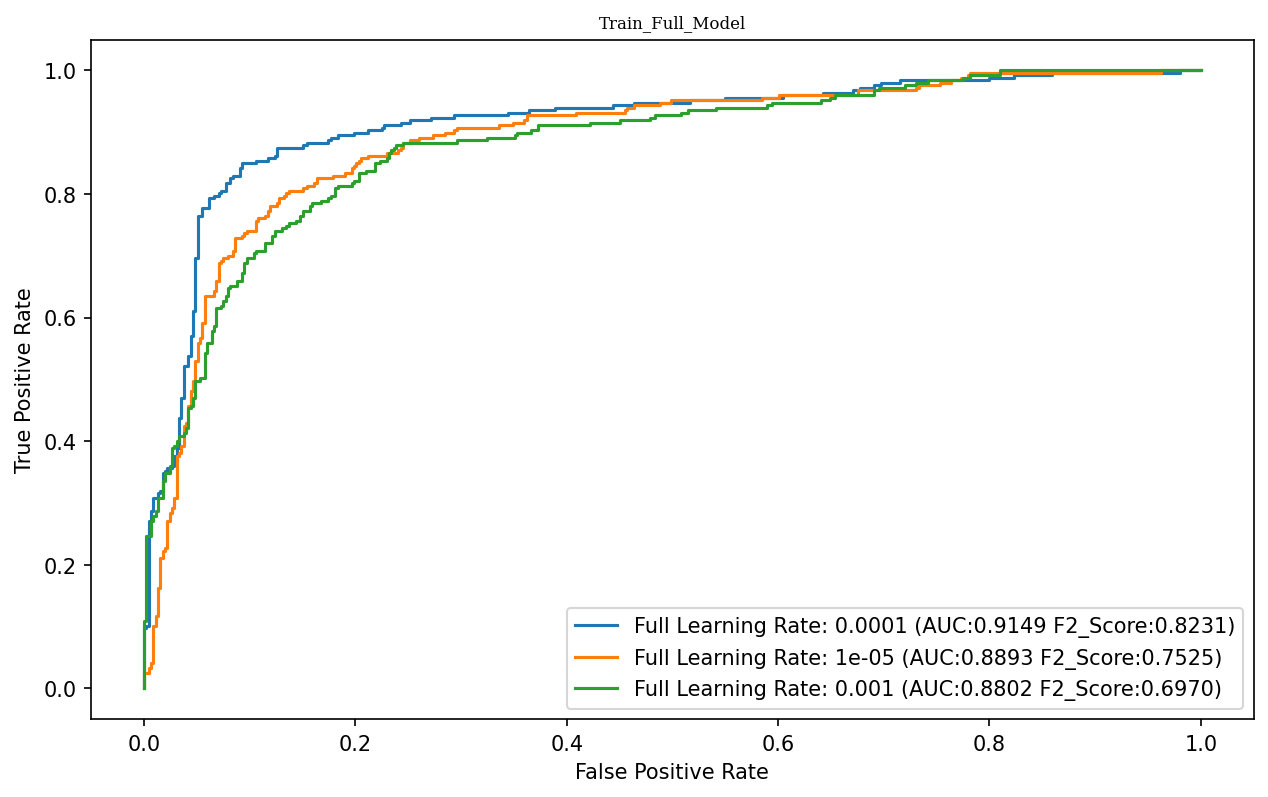

In [10]:
# 使用全量数据进行Fine-Tuneing，并使用Cross-Validation的方法验证模型的性能 
from sklearn.metrics import roc_auc_score, roc_curve, fbeta_score # 导入sklearn.metrics以输出模型的ROC-AUC和F2-score

threshold = 0.5 

train_full_results = {} 

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 8} 

lr_ft = [1e-5, 1e-4, 1e-3] # 学习率
for i in range(len(lr_ft)): # 循环输入每个学习率   
    clf = MolTrain(task='classification', 
                   data_type='molecule',
                   epochs=20,
                   learning_rate=lr_ft[i],
                   batch_size=16,
                   early_stopping=5,
                   metrics='auc',
                   split='random',
                   save_path='./full_learning_rate_'+str(lr_ft[i]),
                  )
    
    clf.fit("./mol_train_full.csv") # 训练模型 
    
    cv_results = pd.DataFrame({'pred':clf.cv_pred.flatten(), 
                           'SMILES':train_data_full["SMILES"], 
                           'Target_BBB':train_data_full["TARGET"]}) 
     
    auc = roc_auc_score(cv_results.Target_BBB, cv_results.pred) 
    fpr, tpr, _ = roc_curve(cv_results.Target_BBB, cv_results.pred) 
    f2_score = fbeta_score(
        cv_results.Target_BBB, 
        [1 if p > threshold else 0 for p in cv_results.pred], 
        beta=2
    )
    
    train_full_results[f"Full Learning Rate: {lr_ft[i]}"] = {"AUC": auc, "FPR": fpr, "TPR": tpr, "F2_Score": f2_score} 
    print(f"[Learning Rate: {lr_ft[i]}]\tAUC:{auc:.4f}\tF2_Score:{f2_score:.4f}") 

sorted_train_full_results = sorted(train_full_results.items(), key=lambda x: x[1]["F2_Score"], reverse=True) # 根据AUC对结果进行排序

# 绘制ROC曲线
plt.figure(figsize=(10, 6), dpi=150)
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

for name, result in sorted_train_full_results:
    if name.startswith("Full Learning Rate"):
        plt.plot(result["FPR"], result["TPR"], label=f"{name} (AUC:{result['AUC']:.4f} F2_Score:{result['F2_Score']:.4f})")

plt.legend(loc="lower right") 
plt.title("Train_Full_Model", fontdict=font) 
plt.show() 

In [11]:
# 使用手动拆分的数据train_data_split进行Fine-Tuneing 
lr_ft = [1e-5, 1e-4, 1e-3] # 学习率
for i in range(len(lr_ft)): # 循环输入每个学习率   
    clf = MolTrain(task='classification', 
                   data_type='molecule',
                   epochs=20,
                   learning_rate=lr_ft[i],
                   batch_size=16,
                   early_stopping=5,
                   metrics='none',
                   split='random',
                   save_path='./split_learning_rate_'+str(lr_ft[i]),
                  )
    
    clf.fit("./mol_train_split.csv") # 训练模型 

2023-11-23 18:51:03 | unimol/data/conformer.py | 62 | INFO | Uni-Mol(QSAR) | Start generating conformers...
500it [00:08, 59.84it/s]
2023-11-23 18:51:12 | unimol/data/conformer.py | 66 | INFO | Uni-Mol(QSAR) | Failed to generate conformers for 0.00% of molecules.
2023-11-23 18:51:12 | unimol/data/conformer.py | 68 | INFO | Uni-Mol(QSAR) | Failed to generate 3d conformers for 0.00% of molecules.
2023-11-23 18:51:12 | unimol/train.py | 102 | INFO | Uni-Mol(QSAR) | Create output directory: ./split_learning_rate_1e-05
2023-11-23 18:51:13 | unimol/models/unimol.py | 116 | INFO | Uni-Mol(QSAR) | Loading pretrained weights from /opt/conda/lib/python3.8/site-packages/unimol-0.0.2-py3.8.egg/unimol/weights/mol_pre_all_h_220816.pt
2023-11-23 18:51:13 | unimol/models/nnmodel.py | 103 | INFO | Uni-Mol(QSAR) | start training Uni-Mol:unimolv1
2023-11-23 18:51:15 | unimol/tasks/trainer.py | 169 | INFO | Uni-Mol(QSAR) | Epoch [1/20] train_loss: 0.6674, val_loss: 0.6486, val_log_loss: 0.6607, lr: 0.0000

### 5.4. “MolPredict”模块的参数说明 
#### load_model:训练好的模型路径 

2023-11-23 19:02:03 | unimol/data/conformer.py | 62 | INFO | Uni-Mol(QSAR) | Start generating conformers...
200it [00:03, 51.07it/s]
2023-11-23 19:02:07 | unimol/data/conformer.py | 66 | INFO | Uni-Mol(QSAR) | Failed to generate conformers for 0.00% of molecules.
2023-11-23 19:02:07 | unimol/data/conformer.py | 68 | INFO | Uni-Mol(QSAR) | Failed to generate 3d conformers for 0.00% of molecules.
2023-11-23 19:02:07 | unimol/models/unimol.py | 116 | INFO | Uni-Mol(QSAR) | Loading pretrained weights from /opt/conda/lib/python3.8/site-packages/unimol-0.0.2-py3.8.egg/unimol/weights/mol_pre_all_h_220816.pt
2023-11-23 19:02:08 | unimol/models/nnmodel.py | 154 | INFO | Uni-Mol(QSAR) | start predict NNModel:unimolv1
2023-11-23 19:02:08 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model success!
2023-11-23 19:02:09 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model success!
2023-11-23 19:02:09 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model s

[Learning Rate: 1e-05]	AUC:0.9043	F2_Score:0.7335


2023-11-23 19:02:11 | unimol/data/conformer.py | 62 | INFO | Uni-Mol(QSAR) | Start generating conformers...
200it [00:03, 50.99it/s]
2023-11-23 19:02:15 | unimol/data/conformer.py | 66 | INFO | Uni-Mol(QSAR) | Failed to generate conformers for 0.00% of molecules.
2023-11-23 19:02:15 | unimol/data/conformer.py | 68 | INFO | Uni-Mol(QSAR) | Failed to generate 3d conformers for 0.00% of molecules.
2023-11-23 19:02:16 | unimol/models/unimol.py | 116 | INFO | Uni-Mol(QSAR) | Loading pretrained weights from /opt/conda/lib/python3.8/site-packages/unimol-0.0.2-py3.8.egg/unimol/weights/mol_pre_all_h_220816.pt
2023-11-23 19:02:16 | unimol/models/nnmodel.py | 154 | INFO | Uni-Mol(QSAR) | start predict NNModel:unimolv1
2023-11-23 19:02:16 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model success!
2023-11-23 19:02:17 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model success!
2023-11-23 19:02:18 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model s

[Learning Rate: 0.0001]	AUC:0.9323	F2_Score:0.6687


2023-11-23 19:02:20 | unimol/data/conformer.py | 62 | INFO | Uni-Mol(QSAR) | Start generating conformers...
200it [00:03, 53.26it/s]
2023-11-23 19:02:23 | unimol/data/conformer.py | 66 | INFO | Uni-Mol(QSAR) | Failed to generate conformers for 0.00% of molecules.
2023-11-23 19:02:23 | unimol/data/conformer.py | 68 | INFO | Uni-Mol(QSAR) | Failed to generate 3d conformers for 0.00% of molecules.
2023-11-23 19:02:24 | unimol/models/unimol.py | 116 | INFO | Uni-Mol(QSAR) | Loading pretrained weights from /opt/conda/lib/python3.8/site-packages/unimol-0.0.2-py3.8.egg/unimol/weights/mol_pre_all_h_220816.pt
2023-11-23 19:02:24 | unimol/models/nnmodel.py | 154 | INFO | Uni-Mol(QSAR) | start predict NNModel:unimolv1
2023-11-23 19:02:25 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model success!
2023-11-23 19:02:25 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model success!
2023-11-23 19:02:26 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model s

[Learning Rate: 0.001]	AUC:0.8854	F2_Score:0.7681


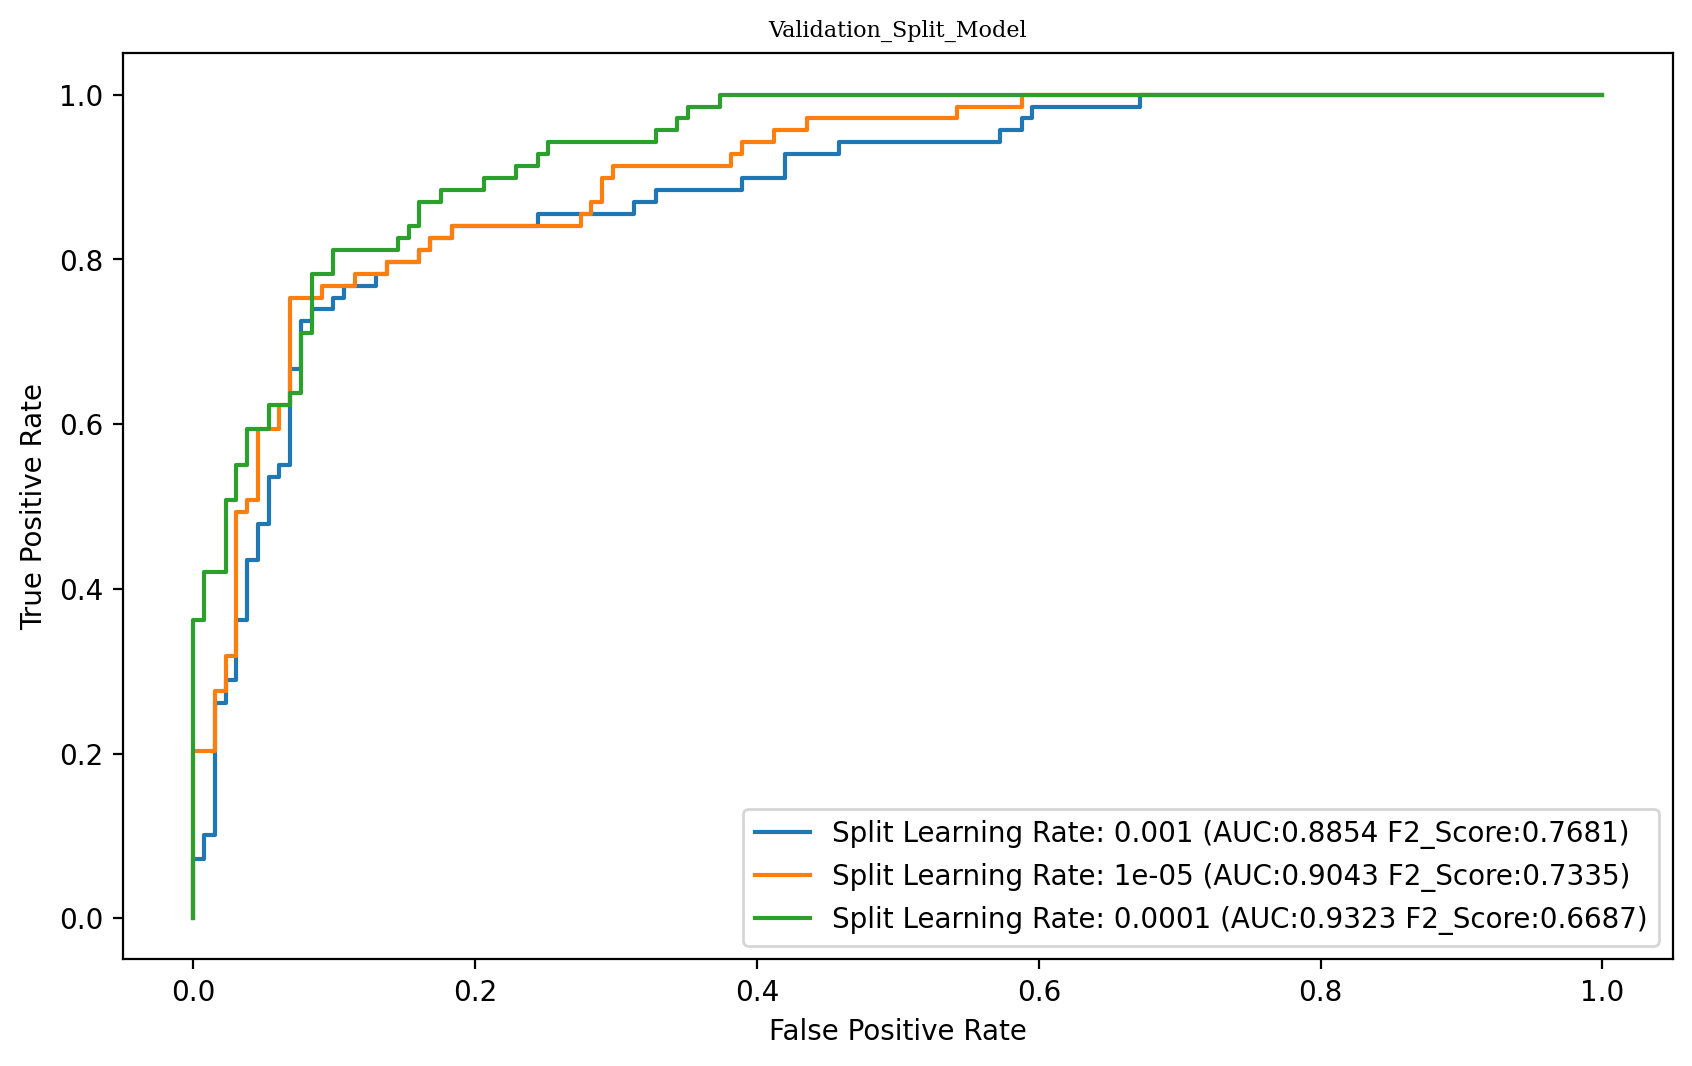

In [12]:
# 使用手动拆分的数据valid_data_split验证模型的性能 
threshold = 0.5

valid_split_results = {} 

lr_ft = [1e-5, 1e-4, 1e-3] # 学习率
for i in range(len(lr_ft)): # 循环输入每个学习率 
    valid_pred_model = MolPredict(load_model='./split_learning_rate_'+str(lr_ft[i])) # 载入不同学习率下的模型 
    
    valid_pred = valid_pred_model.predict("./mol_valid_split.csv") #对测试数据进行预测 
    
    valid_results = pd.DataFrame({'pred':valid_pred.reshape(-1), 
                           'SMILES':valid_data_split["SMILES"], 
                           'Target_BBB':valid_data_split["TARGET"]}) 
    
    auc = roc_auc_score(valid_results.Target_BBB, valid_results.pred) 
    fpr, tpr, _ = roc_curve(valid_results.Target_BBB, valid_results.pred) 
    f2_score = fbeta_score(
        valid_results.Target_BBB, 
        [1 if p > threshold else 0 for p in valid_results.pred], 
        beta=2
    )
    
    valid_split_results[f"Split Learning Rate: {lr_ft[i]}"] = {"AUC": auc, "FPR": fpr, "TPR": tpr, "F2_Score": f2_score} 
    print(f"[Learning Rate: {lr_ft[i]}]\tAUC:{auc:.4f}\tF2_Score:{f2_score:.4f}") 

sorted_valid_split_results = sorted(valid_split_results.items(), key=lambda x: x[1]["F2_Score"], reverse=True) # 根据AUC对结果进行排序

# 绘制ROC曲线
plt.figure(figsize=(10, 6), dpi=200)
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

for name, result in sorted_valid_split_results:
    if name.startswith("Split Learning Rate"):
        plt.plot(result["FPR"], result["TPR"], label=f"{name} (AUC:{result['AUC']:.4f} F2_Score:{result['F2_Score']:.4f})")

plt.legend(loc="lower right") 
plt.title("Validation_Split_Model", fontdict=font) 
plt.show() 

## 6. 使用效果最好的模型对测试数据进行预测 

In [9]:
# 使用全量数据训练的模型在对test数据进行预测 
threshold = 0.5

test_full_pred_model = MolPredict(load_model='./full_learning_rate_'+str(1e-4)) # 载入不同学习率下的模型 

test_smi = {"SMILES": test_data["SMILES"].values.tolist()} 

test_full_pred = test_full_pred_model.predict(test_smi["SMILES"]) #对测试数据进行预测 
    
test_full_results = pd.DataFrame({'pred':test_full_pred.reshape(-1), 
                                  'SMILES':test_data["SMILES"]}) 

test_full_results["TARGET"] = [1 if x > threshold else 0 for x in test_full_results["pred"].values.tolist()] 

test_full_results[["SMILES", "TARGET"]].to_csv('./Full_Model_Submission.csv', index=False, header=True) 

2023-11-20 18:55:03 | unimol/data/conformer.py | 62 | INFO | Uni-Mol(QSAR) | Start generating conformers...
367it [00:07, 48.62it/s]
2023-11-20 18:55:10 | unimol/data/conformer.py | 66 | INFO | Uni-Mol(QSAR) | Failed to generate conformers for 0.00% of molecules.
2023-11-20 18:55:10 | unimol/data/conformer.py | 68 | INFO | Uni-Mol(QSAR) | Failed to generate 3d conformers for 0.00% of molecules.
2023-11-20 18:55:11 | unimol/models/unimol.py | 116 | INFO | Uni-Mol(QSAR) | Loading pretrained weights from /opt/conda/lib/python3.8/site-packages/unimol-0.0.2-py3.8.egg/unimol/weights/mol_pre_all_h_220816.pt
2023-11-20 18:55:11 | unimol/models/nnmodel.py | 154 | INFO | Uni-Mol(QSAR) | start predict NNModel:unimolv1
2023-11-20 18:55:13 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model success!
2023-11-20 18:55:16 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model success!
2023-11-20 18:55:19 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model s

In [11]:
# 使用手动拆分的数据训练的模型对test数据进行预测 
test_split_pred_model = MolPredict(load_model='./split_learning_rate_'+str(1e-3)) # 载入不同学习率下的模型 

test_split_pred = test_split_pred_model.predict(test_smi["SMILES"]) #对测试数据进行预测 
    
test_split_results = pd.DataFrame({'pred':test_split_pred.reshape(-1), 
                                   'SMILES':test_data["SMILES"]}) 

test_split_results["TARGET"] = [1 if x > threshold else 0 for x in test_split_pred["pred"].values.tolist()] 

test_split_results[["SMILES", "TARGET"]].to_csv('./Split_Model_Submission.csv', index=False, header=True) 

2023-11-20 18:56:38 | unimol/data/conformer.py | 62 | INFO | Uni-Mol(QSAR) | Start generating conformers...
367it [00:07, 47.77it/s]
2023-11-20 18:56:46 | unimol/data/conformer.py | 66 | INFO | Uni-Mol(QSAR) | Failed to generate conformers for 0.00% of molecules.
2023-11-20 18:56:46 | unimol/data/conformer.py | 68 | INFO | Uni-Mol(QSAR) | Failed to generate 3d conformers for 0.00% of molecules.
2023-11-20 18:56:47 | unimol/models/unimol.py | 116 | INFO | Uni-Mol(QSAR) | Loading pretrained weights from /opt/conda/lib/python3.8/site-packages/unimol-0.0.2-py3.8.egg/unimol/weights/mol_pre_all_h_220816.pt
2023-11-20 18:56:47 | unimol/models/nnmodel.py | 154 | INFO | Uni-Mol(QSAR) | start predict NNModel:unimolv1
2023-11-20 18:56:47 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model success!
2023-11-20 18:56:48 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model success!
2023-11-20 18:56:50 | unimol/tasks/trainer.py | 213 | INFO | Uni-Mol(QSAR) | load model s

,pred,SMILES
0,0.030412,CC(CCC(=O)O)C1CCC2C3C(CC(=O)C12C)C4(C)CCC(=O)C...
1,0.774587,CC(=O)c1ccc2c(c1)Sc3ccccc3N2CCCN4CCN(CC4)CCO
2,0.036411,CCCN(CCC)C(=O)C(CCC(=O)OCCCN1CCN(CCOC(=O)Cc2c(...
3,0.032624,CC(C)CCCC(C)CCCC(C)CCCC1(C)CCc2c(C)c(O)c(C)c(C...
4,0.685985,CCCN(CCC)CCc1cccc2c1CC(=O)N2
